# Import libraries

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier

#read data

In [5]:
car_features=pd.read_json(r"/content/car.json")

In [6]:
car_features

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1
394,44.0,4,97.0,52,2130,24.6,82,2
395,32.0,4,135.0,84,2295,11.6,82,1
396,28.0,4,120.0,79,2625,18.6,82,1


In [7]:
car_features.isnull().sum()

,0
mpg,0
cyl,0
disp,0
hp,0
wt,0
acc,0
yr,0
origin,0


* there is no null values

# feature description


1.**mpg**:
Miles Per Gallon. This column represents the fuel efficiency of the car, indicating how many miles the car can travel on one gallon of fuel.

2.**cyl**:
Cylinders. This indicates the number of cylinders in the car's engine. More cylinders typically imply more power, but may also lead to higher fuel consumption.

3.**disp:**
Displacement. This refers to the total volume of all the cylinders in the engine, usually measured in cubic inches (cu in) or liters. It gives an indication of the engine's size and power.

4.**hp:**
Horsepower. This column represents the power output of the car's engine. It measures how much work the engine can perform over time.

5.**wt:**
Weight. This refers to the weight of the car, typically measured in pounds (lbs). Heavier cars may have different performance characteristics compared to lighter ones.

6.**acc:**
Acceleration. This generally measures the time it takes for the car to go from 0 to 60 miles per hour. It is often expressed in seconds.

7.**yr:**
Year. This indicates the model year of the car, usually represented in the last two digits (e.g., '70' corresponds to 1970).

8.**origin:**
Origin. This column typically indicates the origin of the car, often represented by numerical codes:
1: American-made
2: European-made
3: Asian-

9.**car name**

#### Data concatenation

In [8]:
car_names = pd.read_csv('/content/Car name.csv', header=None, names=["Car Name"])

# Remove the first element from car names (which it was car_name)
car_names = car_names.drop(0).reset_index(drop=True)
# Reset the index for the car features to match the modified car names
car_features = car_features.reset_index(drop=True)
merged_data = pd.concat([car_names, car_features], axis=1)

In [9]:
merged_data.head()

,Car Name,mpg,cyl,disp,hp,wt,acc,yr,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
4,ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [10]:
(merged_data == '?').sum()

,0
Car Name,0
mpg,0
cyl,0
disp,0
hp,6
wt,0
acc,0
yr,0
origin,0


In [11]:
merged_data.replace('?', np.nan, inplace=True)
merged_data['hp'] = pd.to_numeric(merged_data['hp'], errors='coerce')
merged_data['hp'].fillna(merged_data['hp'].median(), inplace=True)

In [12]:
(merged_data == '?').sum()

,0
Car Name,0
mpg,0
cyl,0
disp,0
hp,0
wt,0
acc,0
yr,0
origin,0


In [13]:
merged_data['power_to_weight'] = merged_data['hp'] / merged_data['wt']

* Power-to-weight is a well-known metric in automotive engineering
* using hp (horsepower) and wt (weight) separately may not fully capture their combined impact on fuel consumption. By creating the power-to-weight ratio, we create a new feature that might highlight how these two factors work together to influence fuel efficiency
* Instead of feeding both hp and wt into the model, combining them into one feature reduces the complexity and can make the model more interpretable while retaining the most relevant information


In [14]:
numerical_features = [
    'disp',
    'power_to_weight',
    'hp',
    'wt',
]
categorical_features = [
'cyl',
'origin'
]

In [15]:
scaler = StandardScaler()
# Apply standardization
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

In [16]:
merged_data

,Car Name,mpg,cyl,disp,hp,wt,acc,yr,origin,power_to_weight
0,chevrolet chevelle malibu,18.0,8,1.090604,0.673118,0.630870,12.0,70,1,0.369595
1,buick skylark 320,15.0,8,1.503514,1.589958,0.854333,11.5,70,1,1.638144
2,plymouth satellite,18.0,8,1.196232,1.197027,0.550470,11.0,70,1,1.466791
3,amc rebel sst,16.0,8,1.061796,1.197027,0.546923,12.0,70,1,1.473177
4,ford torino,17.0,8,1.042591,0.935072,0.565841,10.5,70,1,0.953937
...,...,...,...,...,...,...,...,...,...,...
393,ford mustang gl,27.0,4,-0.513026,-0.479482,-0.213324,15.6,82,1,-0.680922
394,vw pickup,44.0,4,-0.925936,-1.370127,-0.993671,24.6,82,2,-1.754060
395,dodge rampage,32.0,4,-0.561039,-0.531873,-0.798585,11.6,82,1,0.286046
396,ford ranger,28.0,4,-0.705077,-0.662850,-0.408411,18.6,82,1,-0.802967


# EDA

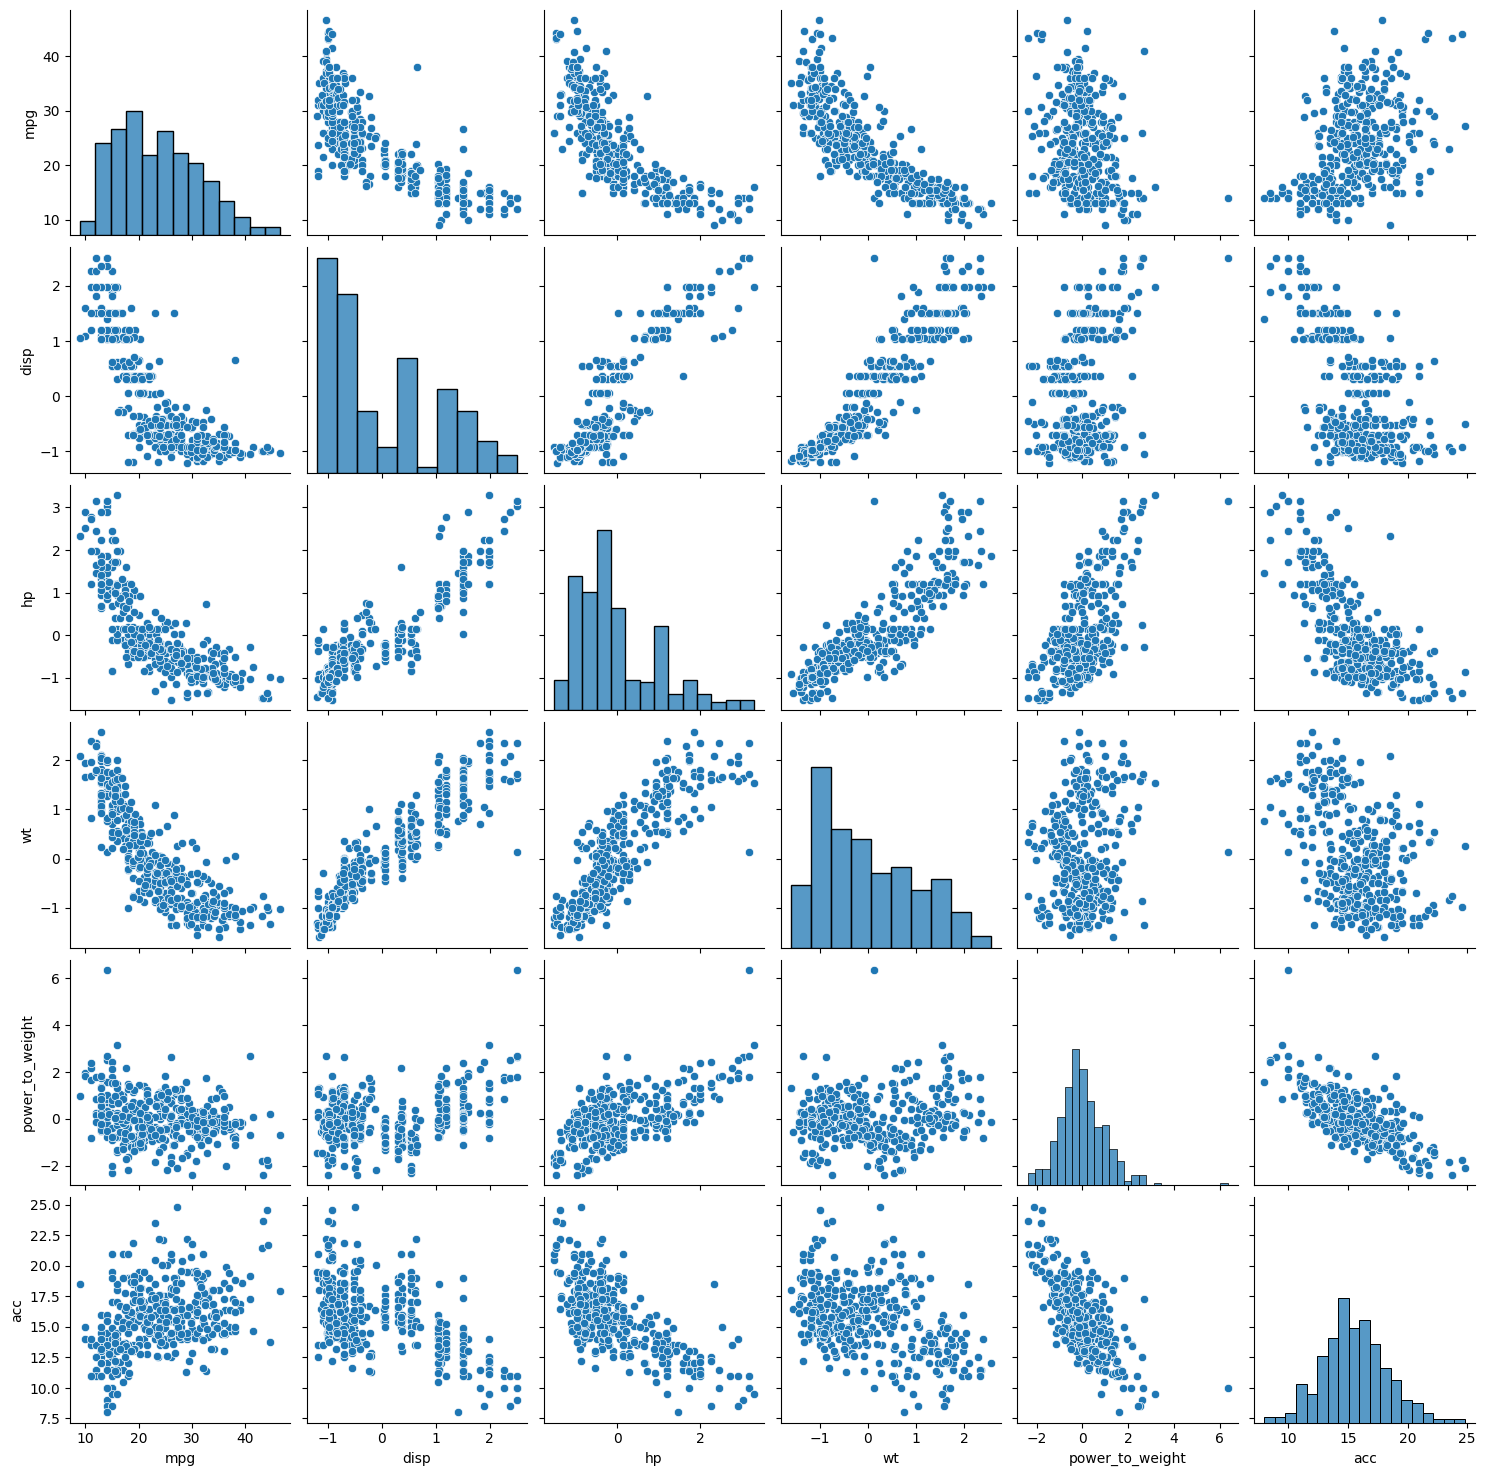

In [17]:
sns.pairplot(merged_data[['mpg', 'disp', 'hp', 'wt', 'power_to_weight','acc']])

* hp is direcly propotional relationship with wt,power_to_weight,disp and inversily propotional relationship with mpg which means the more hp vecheils the less mpg consmuption
* dsip is directly propotional relationship with wt, hp and inversly with mpg
* mpg is inversly propotional with all features
* mpg only directly proption with acc which mean when acc increases the mpg increases

<Axes: >

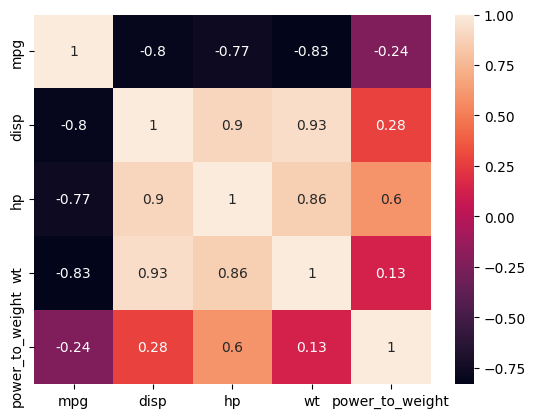

In [18]:
sns.heatmap(merged_data[['mpg', 'disp', 'hp', 'wt', 'power_to_weight']].corr(), annot=True)

# KMean cluster

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(merged_data[numerical_features])

In [20]:
merged_data

,Car Name,mpg,cyl,disp,hp,wt,acc,yr,origin,power_to_weight,cluster
0,chevrolet chevelle malibu,18.0,8,1.090604,0.673118,0.630870,12.0,70,1,0.369595,2
1,buick skylark 320,15.0,8,1.503514,1.589958,0.854333,11.5,70,1,1.638144,2
2,plymouth satellite,18.0,8,1.196232,1.197027,0.550470,11.0,70,1,1.466791,2
3,amc rebel sst,16.0,8,1.061796,1.197027,0.546923,12.0,70,1,1.473177,2
4,ford torino,17.0,8,1.042591,0.935072,0.565841,10.5,70,1,0.953937,2
...,...,...,...,...,...,...,...,...,...,...,...
393,ford mustang gl,27.0,4,-0.513026,-0.479482,-0.213324,15.6,82,1,-0.680922,0
394,vw pickup,44.0,4,-0.925936,-1.370127,-0.993671,24.6,82,2,-1.754060,0
395,dodge rampage,32.0,4,-0.561039,-0.531873,-0.798585,11.6,82,1,0.286046,0
396,ford ranger,28.0,4,-0.705077,-0.662850,-0.408411,18.6,82,1,-0.802967,0


* the cars are clustered in 3 groups

<Axes: xlabel='hp', ylabel='mpg'>

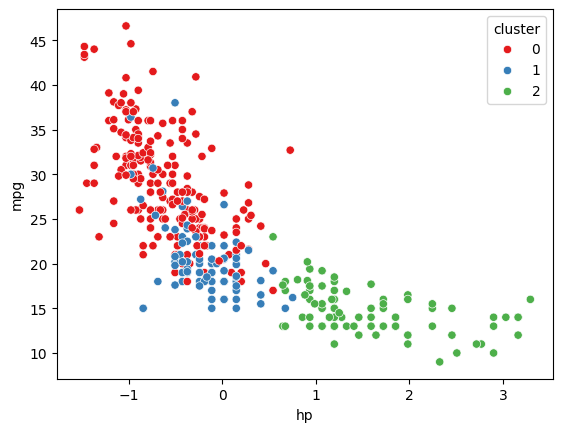

In [21]:
sns.scatterplot(x='hp', y='mpg', hue='cluster', data=merged_data, palette='Set1')


<Axes: xlabel='wt', ylabel='mpg'>

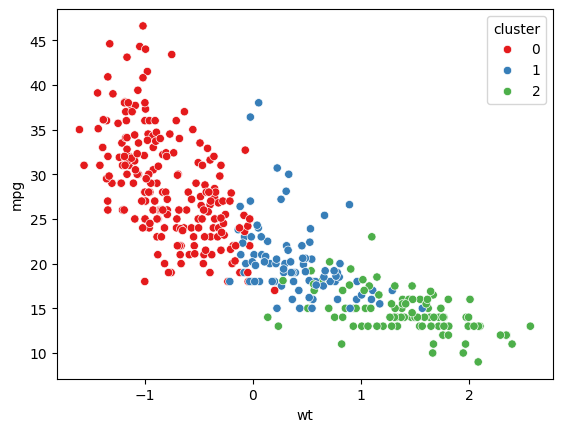

In [22]:
sns.scatterplot(x='wt', y='mpg', hue='cluster', data=merged_data, palette='Set1')

<Axes: xlabel='power_to_weight', ylabel='mpg'>

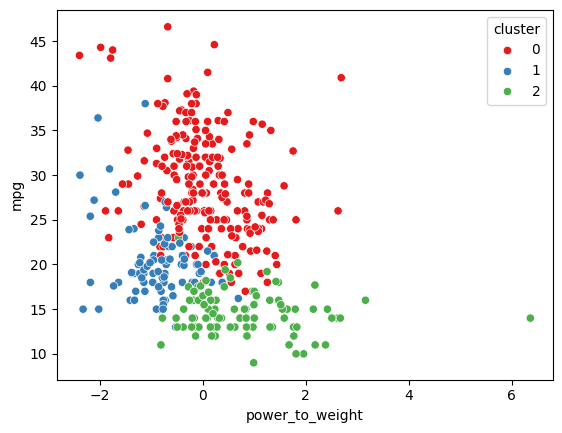

In [23]:
sns.scatterplot(x='power_to_weight', y='mpg', hue='cluster', data=merged_data, palette='Set1')

<Axes: xlabel='acc', ylabel='mpg'>

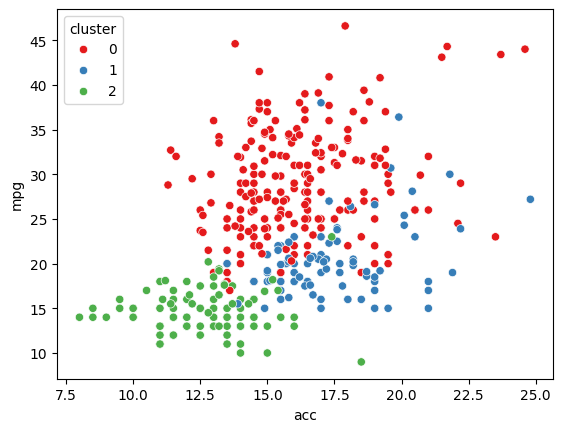

In [24]:
sns.scatterplot(x='acc', y='mpg', hue='cluster', data=merged_data, palette='Set1')

<Axes: xlabel='disp', ylabel='mpg'>

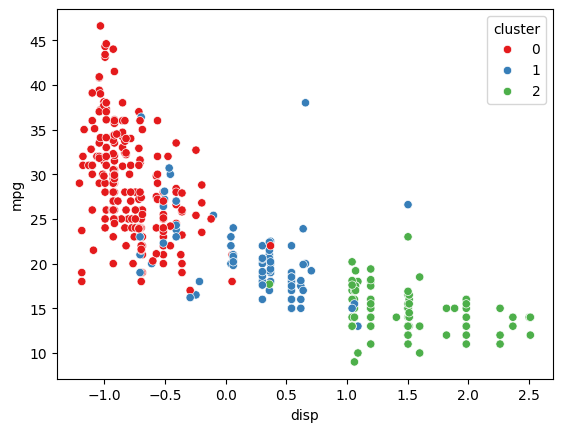

In [25]:
sns.scatterplot(x='disp', y='mpg', hue='cluster', data=merged_data, palette='Set1')

# Superivised prediction

In [26]:
X = merged_data[['disp', 'hp', 'wt', 'power_to_weight']]
y = merged_data['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prediction on linear regression

In [42]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Evaluation

Mean Squared Error: 13.449742811048074


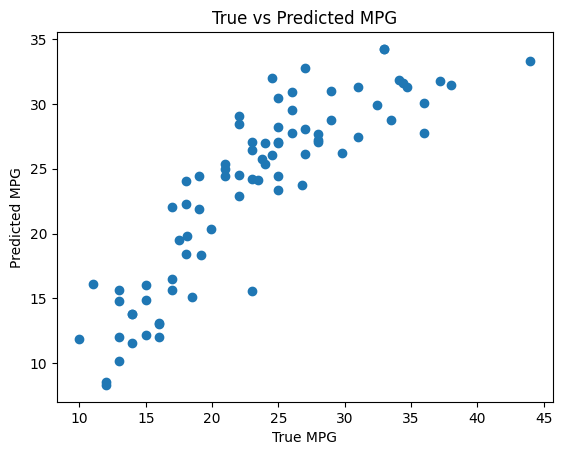

In [43]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Visualize the regression results
plt.scatter(y_test, y_pred)
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.title('True vs Predicted MPG')
plt.show()